# Assignment 1: Dataset Exploration and A Study of the k-Nearest Neighbors Model

### Task/Problem Statement: 
The goal of this assignment is to explore a dataset and study the k-Nearest Neighbors (kNN) model
  for classification.
- Part A: Performance optimization via data standardization, feature selection, & varying 
  threshold for a structured dataset

### Dataset: UCI Adult Income ("Census Income") Dataset
The UCI Adult Income Dataset (also known as the “Census Income” dataset) adult.csv comprises 14
attributes including categorical and numerical features. The target “income” class is a binary
variable (<=50K, >50K). The prediction task is to determine whether a person makes over 50K a year.

Data provided in adult.xlsx comprises 14 attributes including categorical and numerical features.
The target “income” class is a binary variable (<=50K, >50K).

##### Source: https://archive.ics.uci.edu/dataset/2/adult

##### Input variables:
- age
- workclass
- fnlwgt
- education
- education-num
- marital-status
- occupation
- relatioship
- race
- sex
- capital-gain
- capital-loss
- hours-per-week
- native-country

##### Output variable: 
- Income (<=50K, >50K)




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve

## Load Data & Display Dataset Information

Load the excel file as a Pandas DataFrame object. Name it "df". Display the first 5 rows of the DataFrame.

In [2]:
df = None

# the following try-except block tries to handle alternate file types for the data
try:
    df = pd.read_csv("adult.csv")
except FileNotFoundError:
    try:
        df = pd.read_excel("adult.xlsx", sheet_name="in")
    except FileNotFoundError:
        print("adult.xlsx or adult.csv not found")
        exit(1)

print(df.head(5))

    age          workclass  fnlwgt   education  education-num  \
0   NaN          State-gov   77516   Bachelors             13   
1  50.0   Self-emp-not-inc   83311   Bachelors             13   
2  38.0            Private  215646     HS-grad              9   
3  53.0            Private  234721        11th              7   
4  28.0            Private  338409   Bachelors             13   

        marital-status          occupation     relatioship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States 

In [3]:
# Display a summary of the dataset information.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32560 non-null  float64
 1   workclass       32561 non-null  object 
 2   fnlwgt          32561 non-null  int64  
 3   education       32561 non-null  object 
 4   education-num   32561 non-null  int64  
 5   marital-status  32561 non-null  object 
 6   occupation      32561 non-null  object 
 7   relatioship     32561 non-null  object 
 8   race            32561 non-null  object 
 9   sex             32561 non-null  object 
 10  capital-gain    32561 non-null  int64  
 11  capital-loss    32561 non-null  int64  
 12  hours-per-week  32561 non-null  int64  
 13  native-country  32561 non-null  object 
 14  income          32561 non-null  object 
dtypes: float64(1), int64(5), object(9)
memory usage: 3.7+ MB


Display the number of categories and the list of categories for each categorical variable. For 
example, for the categorical variable ‘sex’, display its two categories: ‘Male’ and ‘Female’

In [4]:
# seems like a good place to temporarily break out a seperate DataFrame for the categorical data
category_df = df.select_dtypes(include='object')

def print_categories(columns):
    '''
    Simple function to print the categorical data in standard formatted manner.
    '''
    for column in columns:
        print(f'{column} ({df[column].nunique()}): {df[column].unique()}')
        
print_categories(category_df.columns)

workclass (9): [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
education (16): [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
marital-status (7): [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
occupation (15): [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
relatioship (6): [' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']
race (5): [' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']
sex (2): [' Male' ' Female']
native-country (42): [' Un

## Data Pre-processing


Some columns may contain “?” values. Programmatically replace these "?" values with NaN values.
strip() is used to remove leading and trailing whitespaces.

In [5]:
category_df = category_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
category_df = category_df.replace('?', None)

missing_values = category_df.isnull().sum()
missing_values = missing_values[missing_values > 0]

Impute the missing values with the mode value for categorical variables. This is slightly different
than the instructions which assumes that cleaning up the redundancies 

In [6]:
for column in missing_values.index:
    mode = category_df[column].mode()[0]
    category_df[column] = category_df[column].fillna(mode)
    print(f'Feature ({column}): {missing_values[column]} missing values. Imputed with ({mode}).')

Feature (workclass): 1836 missing values. Imputed with (Private).
Feature (occupation): 1843 missing values. Imputed with (Prof-specialty).
Feature (native-country): 583 missing values. Imputed with (United-States).


In [7]:
# One-hot encode the categorical features and combine the one-hot encoded features with the non-
# categorical columns. Ensure that only (n-1) columns are added for a categorical variable with n 
# categories. The DataFrame object “df” should include all one-hot encoded and non-categorical 
# features. Finally, display the first five rows of the modified “df
onehot_df = pd.get_dummies(category_df, drop_first=True).astype(int)
df = df.drop(columns=category_df.columns)
df = pd.concat([df, onehot_df], axis=1)
print(df.head(5))

    age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   NaN   77516             13          2174             0              40   
1  50.0   83311             13             0             0              13   
2  38.0  215646              9             0             0              40   
3  53.0  234721              7             0             0              40   
4  28.0  338409             13             0             0              40   

   workclass_Local-gov  workclass_Never-worked  workclass_Private  \
0                    0                       0                  0   
1                    0                       0                  0   
2                    0                       0                  1   
3                    0                       0                  1   
4                    0                       0                  1   

   workclass_Self-emp-inc  ...  native-country_Puerto-Rico  \
0                       0  ...                        

In [8]:
# Display a list of the feature names along with their indices. 
# For example, the first feature (index 0) is “age”.
print("Index: Feature Name")
for i, column in enumerate(df.columns):
    print(f'{i}: {column}')

Index: Feature Name
0: age
1: fnlwgt
2: education-num
3: capital-gain
4: capital-loss
5: hours-per-week
6: workclass_Local-gov
7: workclass_Never-worked
8: workclass_Private
9: workclass_Self-emp-inc
10: workclass_Self-emp-not-inc
11: workclass_State-gov
12: workclass_Without-pay
13: education_11th
14: education_12th
15: education_1st-4th
16: education_5th-6th
17: education_7th-8th
18: education_9th
19: education_Assoc-acdm
20: education_Assoc-voc
21: education_Bachelors
22: education_Doctorate
23: education_HS-grad
24: education_Masters
25: education_Preschool
26: education_Prof-school
27: education_Some-college
28: marital-status_Married-AF-spouse
29: marital-status_Married-civ-spouse
30: marital-status_Married-spouse-absent
31: marital-status_Never-married
32: marital-status_Separated
33: marital-status_Widowed
34: occupation_Armed-Forces
35: occupation_Craft-repair
36: occupation_Exec-managerial
37: occupation_Farming-fishing
38: occupation_Handlers-cleaners
39: occupation_Machine-

0    0
1    0
2    0
3    0
4    0
Name: income_>50K, dtype: int32


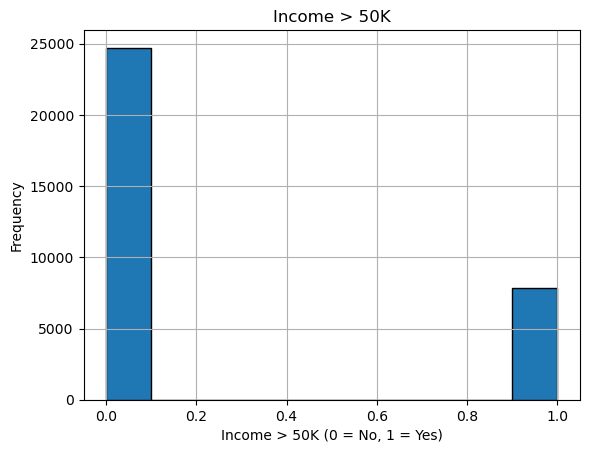

In [9]:
# Display the first five values of the binary target column (0s and 1s). Create a histogram of the
# target column (i.e., income_>50K).
print(df['income_>50K'].head(5))
df['income_>50K'].hist(edgecolor='black', rwidth=1)
plt.title('Income > 50K')
plt.xlabel('Income > 50K (0 = No, 1 = Yes)')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Identify the features (columns) with missing values in the “df”. For each feature with missing
# values, display the total count of missing values.
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
for column in missing_values.index:
    print(f'Feature ({column}): {missing_values[column]} missing values')

Feature (age): 1 missing values


In [11]:
# Replace the missing values in each feature with the median value. First, compute the median of
# each feature. Then, replace the missing values with these medians. Display the first five rows of
# the modified “df”.
for column in missing_values.index:
    median = df[column].median()
    df[column] = df[column].fillna(median)
    print(f'Feature ({column}): {missing_values[column]} missing values. Imputed with ({median}).')

print("----------------------")
print(df.head(5))

Feature (age): 1 missing values. Imputed with (37.0).
----------------------
    age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0  37.0   77516             13          2174             0              40   
1  50.0   83311             13             0             0              13   
2  38.0  215646              9             0             0              40   
3  53.0  234721              7             0             0              40   
4  28.0  338409             13             0             0              40   

   workclass_Local-gov  workclass_Never-worked  workclass_Private  \
0                    0                       0                  0   
1                    0                       0                  0   
2                    0                       0                  1   
3                    0                       0                  1   
4                    0                       0                  1   

   workclass_Self-emp-inc  ...  native-

## Data Analysis

In [12]:
# Compute the Pearson correlation coefficient (also known as the standard correlation coefficient)
# between the binary target and all features. Display the complete list of correlations.
def homebrew_pearson(x, y):
    x_mean = x.mean()
    y_mean = y.mean()
    x_diff = x - x_mean
    y_diff = y - y_mean
    numerator = (x_diff * y_diff).sum()
    denominator = np.sqrt((x_diff**2).sum() * (y_diff**2).sum())
    return numerator / denominator

for column in df.columns:
    hb_correlation = homebrew_pearson(df[column], df['income_>50K'])
    correlation = df[column].corr(df['income_>50K'])
    print(f'{column}: {correlation} (Homebrew: {hb_correlation})')

age: 0.2340395938452256 (Homebrew: 0.23403959384522655)
fnlwgt: -0.009462557247529289 (Homebrew: -0.009462557247529212)
education-num: 0.33515395269095516 (Homebrew: 0.33515395269094206)
capital-gain: 0.22332881819539652 (Homebrew: 0.22332881819538283)
capital-loss: 0.15052631177035364 (Homebrew: 0.15052631177035353)
hours-per-week: 0.2296890656708146 (Homebrew: 0.22968906567081027)
workclass_Local-gov: 0.0330905715441531 (Homebrew: 0.03309057154415485)
workclass_Never-worked: -0.00825863617457719 (Homebrew: -0.00825863617457707)
workclass_Private: -0.12557318638000592 (Homebrew: -0.125573186380003)
workclass_Self-emp-inc: 0.13946655734052865 (Homebrew: 0.13946655734053828)
workclass_Self-emp-not-inc: 0.030019053961920963 (Homebrew: 0.030019053961921997)
workclass_State-gov: 0.014843290616543844 (Homebrew: 0.014843290616542526)
workclass_Without-pay: -0.011680731190583271 (Homebrew: -0.01168073119058295)
education_11th: -0.08586392327840231 (Homebrew: -0.0858639232783975)
education_12t

## Create Data Matrix X and Target y

In [13]:
# Create a deep copy of the DataFrame object using the copy() method of DataFrame. Name it as
# “df_main”. You will need it for Experiment 5.
df_main = df.copy()

In [14]:
# From “df”, create separate DataFrame objects for the features and the target.
X = df.drop(columns='income_>50K')
y = df['income_>50K']

In [15]:
# Convert the feature and target DataFrame objects into NumPy arrays (X for the feature matrix and
# Y for the target matrix).
X = X.to_numpy()
y = y.to_numpy()

In [16]:
# Display the shape and data type of the feature and target arrays.
print(f'X: {X.shape}, {X.dtype}')
print(f'y: {y.shape}, {y.dtype}')

X: (32561, 97), float64
y: (32561,), int32


[0 1] [24720  7841]


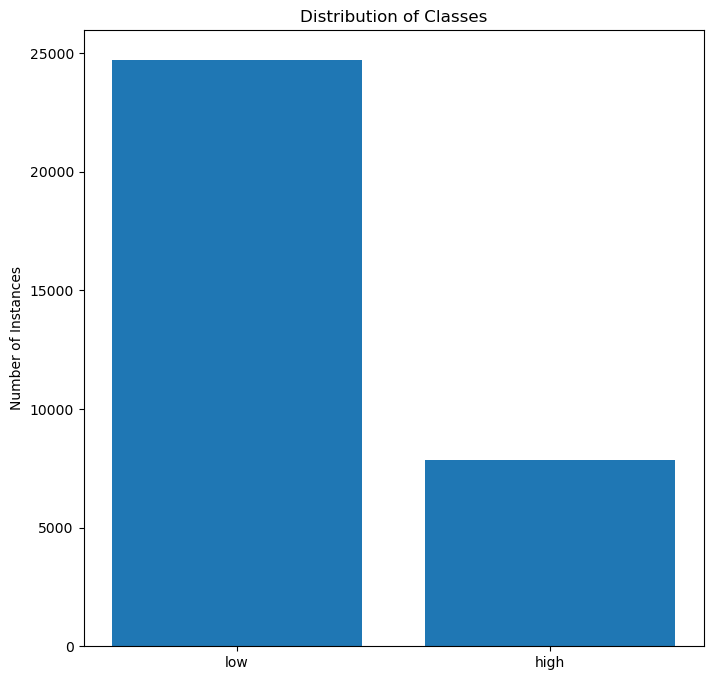

In [17]:
# Create a bar plot for the new target array to show the distribution of samples in the two classes.
# You must use NumPy arrays to create the plot and are not allowed to use DataFrame methods.
# Label the vertical axis as “Number of Instances”. Display the class labels (“high” or “low”) at
# the bottom of each bar on the horizontal axis. The title of the figure should be “Distribution of
# Classes”, and the figure dimensions should be (8, 8).
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)
plt.figure(figsize=(8, 8))
plt.bar(['low', 'high'], counts)
plt.ylabel('Number of Instances')
plt.title('Distribution of Classes')
plt.show()

## Partition the Dataset into Train & Test Subsets

In [18]:
# Partition the dataset into training & test subsets: 80% training & 20% test (you may use
# Scikit-Learn’s train_test_split() function)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Experiments

Perform binary classification using k-NN models for the following experiments. Tune hyperparameters
to determine the optimal values for the following 3 hyperparameters: n_neighbors, p, and weights.

In [19]:
def report_classifier_test_performance(y_labels, y_predictions, verbose=True):
    '''
    Report the performance of a classifier on the test set. Assumes labels and predictions are
    already computed and passed as arguments. Returns the accuracy, precision, recall, F1 score, and
    confusion matrix. If verbose is True, print the results.

    Parameters:
        y_labels (numpy.ndarray): True labels of the test set.
        y_predictions (numpy.ndarray): Predicted labels of the test set.
        verbose (bool): Whether to print the results.

    Returns:
        accuracy (float): The accuracy of the classifier.
        precision (float): The precision of the classifier.
        recall (float): The recall of the classifier.
        f1 (float): The F1 score of the classifier.
        confusion (numpy.ndarray): The confusion matrix of the classifier.
    '''
    accuracy = accuracy_score(y_labels, y_predictions)
    precision = precision_score(y_labels, y_predictions)
    recall = recall_score(y_labels, y_predictions)
    f1 = f1_score(y_labels, y_predictions)
    confusion = confusion_matrix(y_labels, y_predictions)

    if verbose:
        print(f'Test Accuracy: {accuracy}')
        print(f'Test Precision: {precision}')
        print(f'Test Recall: {recall}')
        print(f'Test F1 Score: {f1}')
        print('Test Confusion Matrix:')
        print(confusion)

    return accuracy, precision, recall, f1, confusion


If using GridSearchCV for hyperparameter tuning in the following experiment, consider uncommenting
the following block and limiting the number of CPUs that are available to parallelize the task.
This will help ensure you don't bog down your machine with the grid search.

If necessary install the psutil via `pip install psutil` or `conda install psutil`.

In [20]:
import psutil
p = psutil.Process()
p.cpu_affinity([0, 1, 2, 3, 4, 5]) # Set CPU affinity to the first 6 CPUs, so we don't use all cores

## Experiment 1: All Features + No Standardization

## Experiment 1: All Features + No Standardization

### Model Selection

In [21]:
best_params_ex1 = {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

Skip the following three code blocks if you don't want to spend the time running an extensive grid
search. The top parameters are provided above 

In [47]:
# Define the k-NN classifier and the cross-validation grid search objects
knn_ex1 = KNeighborsClassifier()

parameter_grid_ex1 = {
    "n_neighbors": np.arange(1, 23, 2),
    "p": [1, 2], # previously included powers up to 1000, but it took too long and didn't improve
    "weights": ["uniform", "distance"],
}

grid_search_ex1 = GridSearchCV(knn_ex1, parameter_grid_ex1, cv=5, scoring='f1', n_jobs=-1)

In [48]:
%%time
# Perform the grid search on the training data
_ = grid_search_ex1.fit(X_train, y_train)

CPU times: total: 453 ms
Wall time: 1min 16s


In [49]:
# Display the best hyperparameters and the corresponding F1 score
print(grid_search_ex1.best_params_)
print(grid_search_ex1.best_score_)

best_params_ex1 = grid_search_ex1.best_params_

{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.4547760556093815


### Train a Model Using Optimal Hyperparameters

In [22]:
%%time
# Train the k-NN classifier with the best hyperparameters
knn_ex1 = KNeighborsClassifier(**best_params_ex1)
_ = knn_ex1.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 20.4 ms


### Evaluate the Model 

In [23]:
%%time
# Generate predictions on the training and test sets
train_predictions_ex1 = knn_ex1.predict(X_train)
test_predictions_ex1 = knn_ex1.predict(X_test)

CPU times: total: 1min 1s
Wall time: 13.6 s


In [24]:
# Compute the accuracy of the classifier on the training and test sets to help understand how well
# the classifier generalizes to unseen data.
print(f'Training Accuracy: {accuracy_score(y_train, train_predictions_ex1)}')

_ = report_classifier_test_performance(y_test, test_predictions_ex1)

Training Accuracy: 1.0
Test Accuracy: 0.7680024566252112
Test Precision: 0.5225225225225225
Test Recall: 0.4430299172501591
Test F1 Score: 0.47950396141922147
Test Confusion Matrix:
[[4306  636]
 [ 875  696]]


## Experiment 2: All Features + Standardization

### Standardize the Data

In [25]:
knn_ex2 = KNeighborsClassifier()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Selection

In [26]:
best_params_ex2 = {'n_neighbors': 51, 'p': 1, 'weights': 'distance'}

Skip the following two code blocks if you don't want to spend the time running an extensive grid
search. The top parameters are provided above 

In [80]:
%%time
parameter_grid_ex2 = {
    "n_neighbors": np.arange(1, 63, 2),
    "p": [1, 2, 10, 50, 100, 500, 1000], # previously included powers up to 1000, but it took too long and didn't improve
    "weights": ["uniform", "distance"],
}

grid_search_ex2 = GridSearchCV(knn_ex2, parameter_grid_ex2, cv=5, scoring='f1', n_jobs=-1)
_ = grid_search_ex2.fit(X_train_scaled, y_train)


CPU times: total: 7.5 s
Wall time: 3h 34min 53s


In [82]:
print(grid_search_ex2.best_params_)
print(grid_search_ex2.best_score_)

best_params_ex2 = grid_search_ex2.best_params_

{'n_neighbors': 51, 'p': 1, 'weights': 'distance'}
0.6186874544999409


### Train a Model Using Optimal Hyperparameters

In [27]:
%%time
knn_ex2 = KNeighborsClassifier(**best_params_ex2)
_ = knn_ex2.fit(X_train_scaled, y_train)

CPU times: total: 0 ns
Wall time: 3.73 ms


### Evaluate the Model 

In [28]:
%%time
train_predictions_ex2 = knn_ex2.predict(X_train_scaled)
test_predictions_ex2 = knn_ex2.predict(X_test_scaled)

CPU times: total: 1min
Wall time: 14.8 s


In [29]:
print(f'Training Accuracy: {accuracy_score(y_train, train_predictions_ex2)}')
_ = report_classifier_test_performance(y_test, test_predictions_ex2)

Training Accuracy: 1.0
Test Accuracy: 0.8363273453093812
Test Precision: 0.7008750994431185
Test Recall: 0.5607893061744113
Test F1 Score: 0.6230551626591231
Test Confusion Matrix:
[[4566  376]
 [ 690  881]]


## Experiment 3: Generate Performance Curves for Ex. 2

### Generate ROC Curve

ROC AUC: 0.8851167495848081


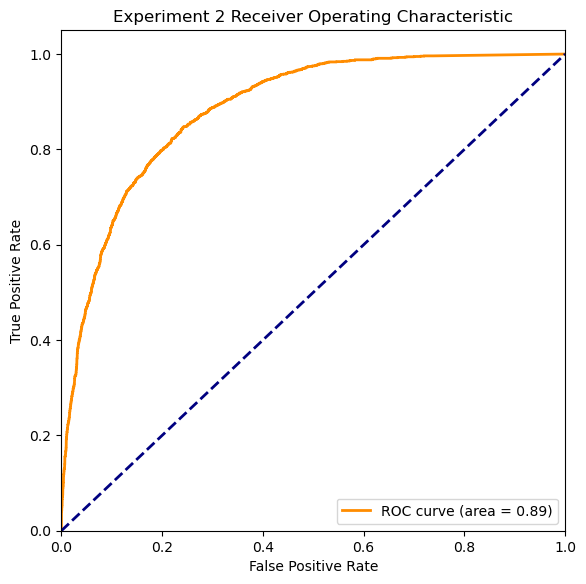

In [30]:
fpr_ex2, tpr_ex2, _ = roc_curve(y_test, knn_ex2.predict_proba(X_test_scaled)[:, 1])
roc_auc_ex2 = auc(fpr_ex2, tpr_ex2)

print(f'ROC AUC: {roc_auc_ex2}')

plt.figure(figsize=(6.5, 6.5))
plt.plot(fpr_ex2, tpr_ex2, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_ex2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Experiment 2 Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Generate Precision-Recall Curves

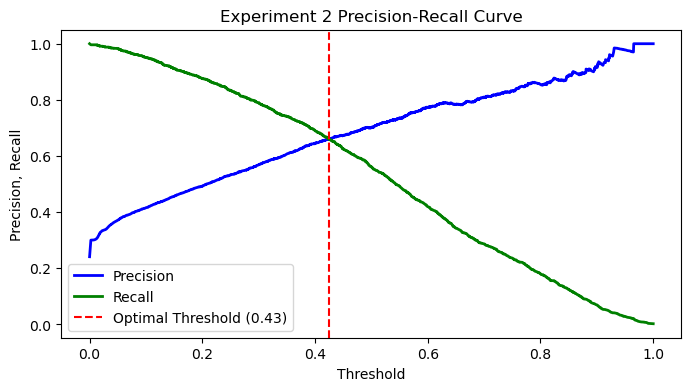

In [31]:
pr_crv = precision_recall_curve(y_test, knn_ex2.predict_proba(X_test_scaled)[:, 1])
precision_ex2, recall_ex2, thresholds_ex2 = pr_crv

optimal_threshold = thresholds_ex2[np.argmin(np.abs(precision_ex2[:-1] - recall_ex2[:-1]))]

plt.figure(figsize=(8, 4))
plt.plot(thresholds_ex2, precision_ex2[:-1], color='blue', lw=2, label='Precision')
plt.plot(thresholds_ex2, recall_ex2[:-1], color='green', lw=2, label='Recall')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Precision, Recall')
plt.title('Experiment 2 Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

### Train a Model Using Optimal Hyperparameters

In [33]:
%%time
knn_ex3 = KNeighborsClassifier(**best_params_ex2)
_ = knn_ex3.fit(X_train_scaled, y_train)

CPU times: total: 0 ns
Wall time: 6.51 ms


### Evaluate the Model 

In [34]:
%%time
train_predictions_ex3 = knn_ex3.predict_proba(X_train_scaled)[:, 1] > optimal_threshold
test_predictions_ex3 = knn_ex3.predict_proba(X_test_scaled)[:, 1] > optimal_threshold

CPU times: total: 1min 2s
Wall time: 13.1 s


In [35]:
print(f'Training Accuracy: {accuracy_score(y_train, train_predictions_ex3)}')
_ = report_classifier_test_performance(y_test, test_predictions_ex3)

Training Accuracy: 1.0
Test Accuracy: 0.8361738062336864
Test Precision: 0.6605095541401274
Test Recall: 0.66008911521324
Test F1 Score: 0.6602992677491245
Test Confusion Matrix:
[[4409  533]
 [ 534 1037]]


## Experiment 4: Conduct Feature Selection

### Feature Selection

In [94]:
from sklearn.feature_selection import SequentialFeatureSelector

knn_ex4 = KNeighborsClassifier()
sfs = SequentialFeatureSelector(knn_ex4, n_features_to_select=10, direction='forward')

The feature selector ran 1h 14min and produced feature indices of [ 3  4 10 22 26 29 36 45 59 74].

In [95]:
%%time
_ = sfs.fit(X_train_scaled, y_train)

CPU times: total: 1h 8min 2s
Wall time: 1h 14min 20s


In [96]:
selected_features = sfs.get_support(indices=True)
print(selected_features)

[ 3  4 10 22 26 29 36 45 59 74]


### Model Selection

In [ ]:
best_params_ex4 = {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

Skip the following two code blocks if you don't want to spend the time running an extensive grid
search. The top parameters are provided above 

In [109]:
%%time
parameter_grid_ex4 = {
    "n_neighbors": np.arange(1, 103, 2),
    "p": [1, 2, 10, 50], #, 100, 500, 1000],
    "weights": ["uniform", "distance"],
}

grid_search_ex4 = GridSearchCV(knn_ex4, parameter_grid_ex4, cv=5, scoring='f1', n_jobs=-1)
_ = grid_search_ex4.fit(X_train_scaled[:, selected_features], y_train)

CPU times: total: 4.08 s
Wall time: 15min 53s


In [112]:
print(grid_search_ex4.best_params_)
print(grid_search_ex4.best_score_)

best_params_ex4 = grid_search_ex4.best_params_

{'n_neighbors': 87, 'p': 1, 'weights': 'distance'}
0.6151145872442795


### Train a Model Using Optimal Hyperparameters

In [113]:
knn_ex4 = KNeighborsClassifier(**best_params_ex4)
_ = knn_ex4.fit(X_train_scaled[:, selected_features], y_train)

### Evaluate Model

In [114]:
print(f'Training Accuracy: {accuracy_score(y_train, knn_ex4.predict(X_train_scaled[:, selected_features]))}')
_ = report_classifier_test_performance(y_test, knn_ex4.predict(X_test_scaled[:, selected_features]))

Training Accuracy: 0.8555359336609336
Test Accuracy: 0.8522954091816367
Test Precision: 0.8072653884964682
Test Recall: 0.5092297899427116
Test F1 Score: 0.624512099921936
Test Confusion Matrix:
[[4751  191]
 [ 771  800]]


### Generate Precision-Recall Curves

In [115]:
pr_crv_ex4 = precision_recall_curve(y_test, knn_ex4.predict_proba(X_test_scaled[:, selected_features])[:, 1])
precision_ex4, recall_ex4, thresholds_ex4 = pr_crv_ex4

optimal_threshold_ex4 = thresholds_ex4[np.argmin(np.abs(precision_ex4[:-1] - recall_ex4[:-1]))]

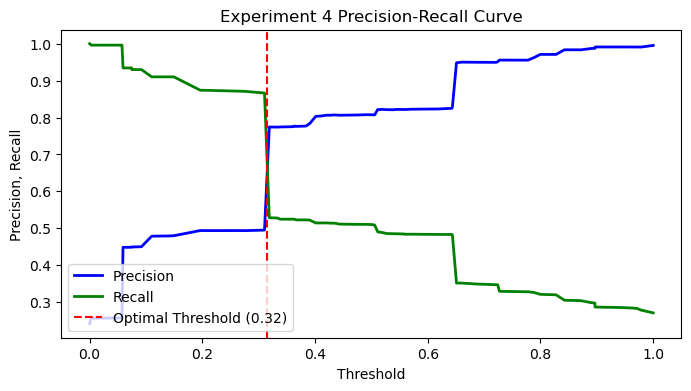

In [123]:
optimal_threshold_ex4 = 0.315
plt.figure(figsize=(8, 4))
plt.plot(thresholds_ex4, precision_ex4[:-1], color='blue', lw=2, label='Precision')
plt.plot(thresholds_ex4, recall_ex4[:-1], color='green', lw=2, label='Recall')
plt.axvline(optimal_threshold_ex4, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold_ex4:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Precision, Recall')
plt.title('Experiment 4 Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [121]:
%%time
train_predictions_ex4b = knn_ex4.predict_proba(X_train_scaled[:, selected_features])[:, 1] > optimal_threshold_ex4
test_predictions_ex4b = knn_ex4.predict_proba(X_test_scaled[:, selected_features])[:, 1] > optimal_threshold_ex4

CPU times: total: 8.22 s
Wall time: 15.7 s


In [122]:
print(f'Training Accuracy: {accuracy_score(y_train, train_predictions_ex4b)}')
_ = report_classifier_test_performance(y_test, test_predictions_ex4b)

Training Accuracy: 0.8523111179361179
Test Accuracy: 0.8490710885920467
Test Precision: 0.7742537313432836
Test Recall: 0.5283259070655634
Test F1 Score: 0.6280741581536133
Test Confusion Matrix:
[[4700  242]
 [ 741  830]]


## Experiment 5: (Grad-only) Manual Feature Selection

For this experiment, use the df_main DataFrame object that you created in the pre-processing stage. 
Ensure that its target column is binary-valued and of integer type before using it. You will select
at least four subsets (each containing at least ten features) to train k-NN models. You may use
Pearson’s correlation coefficient to select features. Your goal is to increase the test accuracy.
You are free to try any combination of features. Justify the selection of features for each subset
in no more than three lines.

In [37]:
# Confirm that df_main has binary value for income_>50K with integer values
print(df_main['income_>50K'].unique(), df_main['income_>50K'].dtype)

[0 1] int32


In [46]:
correlation_matrix = df_main.corr()
correlation_matrix = correlation_matrix['income_>50K'].sort_values(ascending=False)
corr_matrix_abs = correlation_matrix.abs().sort_values(ascending=False)

print("Top-20 Positive Correlations:")
for feature, correlation in correlation_matrix.head(20).items():
    print(f'    {feature}: {correlation}')

print("Top-20 Negative Correlations:")
for feature, correlation in correlation_matrix.tail(20).items():
    print(f'    {feature}: {correlation}')

print("Top-20 Absolute Correlations:")
for feature, correlation in corr_matrix_abs.head(20).items():
    print(f'    {feature}: {correlation}')


Top-20 Positive Correlations:
    income_>50K: 1.0
    marital-status_Married-civ-spouse: 0.4446961550463188
    education-num: 0.3351539526909404
    age: 0.23403959384522818
    hours-per-week: 0.2296890656708114
    capital-gain: 0.22332881819538047
    sex_Male: 0.2159801505840364
    occupation_Exec-managerial: 0.21486131464645059
    education_Bachelors: 0.1804854292020816
    education_Masters: 0.17456971065152524
    education_Prof-school: 0.15490683578936115
    capital-loss: 0.15052631177035347
    workclass_Self-emp-inc: 0.13946655734053753
    education_Doctorate: 0.13257200580963707
    relatioship_Wife: 0.12326353972805554
    occupation_Prof-specialty: 0.11299337481771071
    race_White: 0.08522449750188077
    native-country_United-States: 0.038942084636250894
    workclass_Local-gov: 0.03309057154415488
    workclass_Self-emp-not-inc: 0.030019053961921914
Top-20 Negative Correlations:
    education_5th-6th: -0.04582616682401595
    occupation_Farming-fishing: -0.051924

The feature subsets in following code block were selected based on the following basis:
1. The top-10 positively correlated features were selected because greater correlation
   with the target should inidicate greater discriminability.
2. The top-10 positively correlated features with redundancy removed. Specifically,
   education-num provides a numerical representation of the other education labels. Hence,
   education_Bachelors, education_Masters, etc. were removed.
3. The top-10 negatively correlated features were selected to explore how well the kNN
   model could perform if the features indicate the opposite class.
4. The top-10 absolute correlated features were selected to explore how well the kNN model
   could discriminate positively and negatively correlated features to predict the target.

In [51]:
feature_subsets = [
    ['marital-status_Married-civ-spouse', 'education-num', 'age', 'hours-per-week', 'capital-gain', 'sex_Male', 'occupation_Exec-managerial', 'education_Bachelors', 'education_Masters', 'education_Prof-school'],
    ['marital-status_Married-civ-spouse', 'education-num', 'age', 'hours-per-week', 'capital-gain', 'sex_Male', 'occupation_Exec-managerial', 'capital-loss', 'workclass_Self-emp-inc', 'relatioship_Wife'],
    ['marital-status_Never-married', 'relatioship_Own-child', 'relatioship_Not-in-family', 'occupation_Other-service', 'relatioship_Unmarried', 'education_HS-grad', 'workclass_Private', 'race_Black', 'occupation_Handlers-cleaners', 'education_11th'],
    ['marital-status_Married-civ-spouse', 'education-num', 'marital-status_Never-married', 'age', 'hours-per-week', 'relatioship_Own-child', 'capital-gain', 'sex_Male', 'occupation_Exec-managerial', 'relatioship_Not-in-family'],
]

In [52]:
X_main = df_main.drop(columns='income_>50K')
y_main = df_main['income_>50K']

feature_indices = [[X_main.columns.get_loc(feature) for feature in subset] for subset in feature_subsets]
X_main = X_main.to_numpy()
y_main = y_main.to_numpy()

X_main_train, X_main_test, y_main_train, y_main_test = train_test_split(X_main, y_main, test_size=0.2, random_state=42)

scaler_main = StandardScaler()
X_main_train_scaled = scaler_main.fit_transform(X_main_train)
X_main_test_scaled = scaler_main.transform(X_main_test)


In [54]:
parameter_grid_ex5 = {
    "n_neighbors": np.arange(1, 103, 2),
    "p": [1, 2, 10, 50],
    "weights": ["uniform", "distance"],
}

best_params = []

for f_sub, f_idx in zip(feature_subsets, feature_indices):
    print(f'Feature Subset: {f_sub}')
    
    grid_search_ex5 = GridSearchCV(KNeighborsClassifier(), parameter_grid_ex5, cv=5, scoring='f1', n_jobs=-1)
    _ = grid_search_ex5.fit(X_main_train_scaled[:, f_idx], y_main_train)
    
    print(grid_search_ex5.best_params_)
    print(grid_search_ex5.best_score_)
    print()

    best_params.append(grid_search_ex5.best_params_)

Feature Subset: ['marital-status_Married-civ-spouse', 'education-num', 'age', 'hours-per-week', 'capital-gain', 'sex_Male', 'occupation_Exec-managerial', 'education_Bachelors', 'education_Masters', 'education_Prof-school']


c:\Users\zmswa\miniconda3\envs\ecen878-base\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}
0.6321018900012678

Feature Subset: ['marital-status_Married-civ-spouse', 'education-num', 'age', 'hours-per-week', 'capital-gain', 'sex_Male', 'occupation_Exec-managerial', 'capital-loss', 'workclass_Self-emp-inc', 'relatioship_Wife']


c:\Users\zmswa\miniconda3\envs\ecen878-base\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'n_neighbors': 21, 'p': 2, 'weights': 'uniform'}
0.6466802449955653

Feature Subset: ['marital-status_Never-married', 'relatioship_Own-child', 'relatioship_Not-in-family', 'occupation_Other-service', 'relatioship_Unmarried', 'education_HS-grad', 'workclass_Private', 'race_Black', 'occupation_Handlers-cleaners', 'education_11th']
{'n_neighbors': 83, 'p': 2, 'weights': 'uniform'}
0.5391069422569927

Feature Subset: ['marital-status_Married-civ-spouse', 'education-num', 'marital-status_Never-married', 'age', 'hours-per-week', 'relatioship_Own-child', 'capital-gain', 'sex_Male', 'occupation_Exec-managerial', 'relatioship_Not-in-family']
{'n_neighbors': 17, 'p': 50, 'weights': 'uniform'}
0.6291449596269121



In [55]:
for f_sub, f_idx, params in zip(feature_subsets, feature_indices, best_params):
    print(f'Feature Subset: {f_sub}')
    print(f'Best Parameters: {params}')
    print()

    knn_ex5 = KNeighborsClassifier(**params)
    _ = knn_ex5.fit(X_main_train_scaled[:, [df_main.columns.get_loc(f) for f in f_sub]], y_main_train)

    print(f'Training Accuracy: {accuracy_score(y_main_train, knn_ex5.predict(X_main_train_scaled[:, [df_main.columns.get_loc(f) for f in f_sub]]))}')
    _ = report_classifier_test_performance(y_main_test, knn_ex5.predict(X_main_test_scaled[:, [df_main.columns.get_loc(f) for f in f_sub]]))

    print()
    

Feature Subset: ['marital-status_Married-civ-spouse', 'education-num', 'age', 'hours-per-week', 'capital-gain', 'sex_Male', 'occupation_Exec-managerial', 'education_Bachelors', 'education_Masters', 'education_Prof-school']
Best Parameters: {'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}

Training Accuracy: 0.8548065110565111
Test Accuracy: 0.8446184553968985
Test Precision: 0.714176245210728
Test Recall: 0.593252705283259
Test F1 Score: 0.6481223922114048
Test Confusion Matrix:
[[4569  373]
 [ 639  932]]

Feature Subset: ['marital-status_Married-civ-spouse', 'education-num', 'age', 'hours-per-week', 'capital-gain', 'sex_Male', 'occupation_Exec-managerial', 'capital-loss', 'workclass_Self-emp-inc', 'relatioship_Wife']
Best Parameters: {'n_neighbors': 21, 'p': 2, 'weights': 'uniform'}

Training Accuracy: 0.8578393734643734
Test Accuracy: 0.8510670965760786
Test Precision: 0.7313317936874519
Test Recall: 0.60471037555697
Test F1 Score: 0.662020905923345
Test Confusion Matrix:
[[4593  34

# Assignment 1: Dataset Exploration and A Study of the k-Nearest Neighbors Model

### Task/Problem Statement: 
The goal of this assignment is to explore a dataset and study the k-Nearest Neighbors (kNN) model
for classification.
- Part B: Understanding the curse of dimensionality & the fundamental limitation of the k-NN
  model using an unstructured dataset

### Dataset: CIFAR-10
Contains 60,000 32 x 32 color images in 10 different classes. The 10 different classes represent
airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images
of each class.

##### Description

##### Source: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

##### Input variables:
- 32 x 32 color images (RGB channels)

##### Output variable: 
- Class label (1 of 10 classes)
    - 0. airplane
    - 1. automobile
    - 2. bird
    - 3. cat
    - 4. deer
    - 5. dog
    - 6. frog
    - 7. horse
    - 8. ship
    - 9. truck

In [82]:
from keras.datasets import cifar10
from sklearn.multioutput import MultiOutputClassifier

## Load Data & Display Dataset Information

In [83]:
(X_cifar_train, y_cifar_train), (X_cifar_test, y_cifar_test) = cifar10.load_data()

In [84]:
print(f'Training Set: {X_cifar_train.shape}, {y_cifar_train.shape}')
print(f'Test Set: {X_cifar_test.shape}, {y_cifar_test.shape}')

print(f'Classes: {np.unique(y_cifar_train)}')
print(f'Pixel Range and Type: {X_cifar_train.min()} - {X_cifar_train.max()}, {X_cifar_train.dtype}')

Training Set: (50000, 32, 32, 3), (50000, 1)
Test Set: (10000, 32, 32, 3), (10000, 1)
Classes: [0 1 2 3 4 5 6 7 8 9]
Pixel Range and Type: 0 - 255, uint8


In [85]:

# Display the number of samples for each class in the training set and test set
unique_train, counts_train = np.unique(y_cifar_train, return_counts=True)
unique_test, counts_test = np.unique(y_cifar_test, return_counts=True)

print("Training Set:")
for i, (label, count) in enumerate(zip(unique_train, counts_train)):
    print(f'    Class {label}: {count} samples')

print("Test Set:")
for i, (label, count) in enumerate(zip(unique_test, counts_test)):
    print(f'    Class {label}: {count} samples')

Training Set:
    Class 0: 5000 samples
    Class 1: 5000 samples
    Class 2: 5000 samples
    Class 3: 5000 samples
    Class 4: 5000 samples
    Class 5: 5000 samples
    Class 6: 5000 samples
    Class 7: 5000 samples
    Class 8: 5000 samples
    Class 9: 5000 samples
Test Set:
    Class 0: 1000 samples
    Class 1: 1000 samples
    Class 2: 1000 samples
    Class 3: 1000 samples
    Class 4: 1000 samples
    Class 5: 1000 samples
    Class 6: 1000 samples
    Class 7: 1000 samples
    Class 8: 1000 samples
    Class 9: 1000 samples


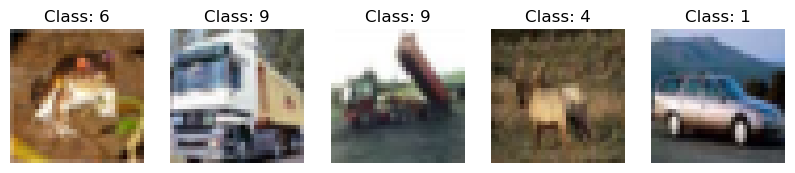

In [86]:

# Display the first 5 images from the training set
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_cifar_train[i])
    plt.axis('off')
    plt.title(f'Class: {y_cifar_train[i][0]}')
    plt.axis('off')

## Data Pre-processing


Before you use this data for the k-NN model, you need to flatten each sample (i.e., 32 x 
32 x 3 = 3072) such that the dimension of the training and test set becomes:
- 50000 x 3072
- 10000 x 3072

In [87]:
X_cifar_train = np.reshape(X_cifar_train, (X_cifar_train.shape[0], -1))
X_cifar_test = np.reshape(X_cifar_test, (X_cifar_test.shape[0], -1))

print(X_cifar_train.shape, X_cifar_test.shape)

(50000, 3072) (10000, 3072)


The train and test labels will be loaded as a 1D column vector. You need to convert the 
1D vector into a 1D array (because the sklearn k-NN model requires the label data to be a 
1D array).

In [88]:
y_cifar_train = y_cifar_train.ravel()
y_cifar_test = y_cifar_test.ravel()

print(y_cifar_train.shape, y_cifar_test.shape)

(50000,) (10000,)


Finally, scale the data using the min-max scaling technique, i.e., by dividing the training 
& test data matrix by 255.0.

In [89]:
X_cifar_train = X_cifar_train.astype('float32') / 255.0
X_cifar_test = X_cifar_test.astype('float32') / 255.0

print(X_cifar_train.min(), X_cifar_train.max(), X_cifar_train.dtype)
print(X_cifar_test.min(), X_cifar_test.max(), X_cifar_test.dtype)

0.0 1.0 float32
0.0 1.0 float32


## Experiment 6: Multiclass kNN Classification

In [90]:
%%time
best_params_ex6 = {'n_neighbors': 5, 'p': 1}
knn_ex6 = KNeighborsClassifier(**best_params_ex6)
# multi_knn_ex6 = MultiOutputClassifier(knn_ex6)
_ = knn_ex6.fit(X_cifar_train, y_cifar_train)

CPU times: total: 156 ms
Wall time: 177 ms


In [91]:
%%time
y_train_predicted = knn_ex6.predict(X_cifar_train)


CPU times: total: 1h 34min 14s
Wall time: 18min 14s


In [94]:
train_accuracy_knn = np.mean(y_train_predicted == y_cifar_train)
print("\nTraining Accuracy: ", train_accuracy_knn)


Training Accuracy:  0.53516


In [95]:
%%time
y_test_predicted = knn_ex6.predict(X_cifar_test)

CPU times: total: 18min 35s
Wall time: 4min 3s


In [96]:
from sklearn.metrics import classification_report
print(classification_report(y_cifar_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.37      0.58      0.45      1000
           1       0.65      0.29      0.40      1000
           2       0.24      0.46      0.32      1000
           3       0.33      0.25      0.28      1000
           4       0.26      0.49      0.34      1000
           5       0.44      0.27      0.33      1000
           6       0.40      0.29      0.34      1000
           7       0.70      0.27      0.39      1000
           8       0.45      0.66      0.54      1000
           9       0.72      0.23      0.34      1000

    accuracy                           0.38     10000
   macro avg       0.46      0.38      0.37     10000
weighted avg       0.46      0.38      0.37     10000



In [97]:
pd.crosstab(y_cifar_test, y_test_predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,582,9,101,10,49,7,25,7,195,15,1000
1,139,288,89,50,130,40,44,17,168,35,1000
2,145,5,456,54,206,30,55,13,34,2,1000
3,82,11,215,246,162,109,101,14,52,8,1000
4,92,4,259,40,489,18,43,14,40,1,1000
5,72,4,214,151,166,266,64,14,43,6,1000
6,36,4,259,74,285,27,288,1,25,1,1000
7,116,10,155,50,259,58,38,267,37,10,1000
8,154,20,47,33,43,17,10,6,662,8,1000
